# Chapter 6, exercises 7 and 8

* Generate a moons toy dataset
* Split into training and test sets
* Explore hyperparameters for a DecisionTreeClassifier
  + hint: vary max_leaf_nodes
* Train on the full training set and measure performance on test set
  + Should have ~85 to 87% accuracy
* Grow a forest
  + Generate 1000 subsets of 100 random data points from training data
  + Train one tree for each subset, using best hyperparameters
    * Look at accuracy of training
  + For each test instance get the prediction of every tree
    * Keep the most frequent prediction and evaluate on the test set

## Set up

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

In [22]:
# Common imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
# Settings

# Matplotlib
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

# Pandas
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

# Numpy
# np.random.seed(42)  # to make this notebook's output stable across runs

## Get Data

In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

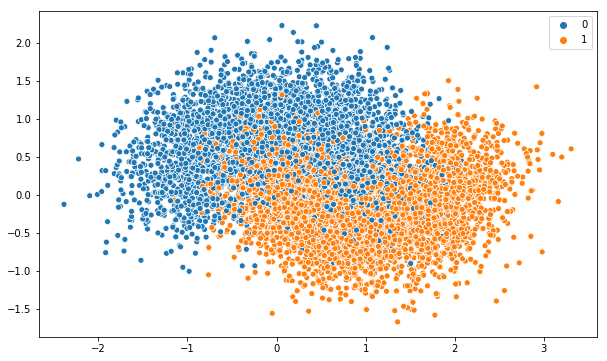

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(X_train[:, 0], X_train[:, 1], hue=y_train)
plt.show()

## Decision Tree

In [20]:
# Default tree parameters - CV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree_clf = DecisionTreeClassifier()

tree_clf.fit(X_train, y_train)

cv_score = cross_val_score(tree_clf, X_train, y_train, cv=10, scoring="accuracy")

print('{0:.2f} +/- {1:.2f}'.format(cv_score.mean(), cv_score.std()))

0.80 +/- 0.01


In [47]:
# Hyperparameter tuning - Grid max_leaf_nodes
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': [2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 100, 1000]}

grid_search = GridSearchCV(tree_clf, param_grid, cv=10, iid=False, 
                           return_train_score=True)

grid_search.fit(X_train, y_train)

print('best parameters {0}'.format(grid_search.best_params_))

cvres = pd.DataFrame(grid_search.cv_results_)
cvres.rename({'param_max_leaf_nodes':'max_leaf_nodes', 
              'mean_test_score':'score'},
             axis=1, inplace=True)
cvres[['max_leaf_nodes', 'score']].sort_values(by='score', ascending=False)

best parameters {'max_leaf_nodes': 30}


,max_leaf_nodes,score
8,30,0.861003
7,20,0.858125
9,40,0.858004
10,50,0.853004
2,4,0.851504
3,5,0.851504
4,6,0.851504
5,8,0.851504
11,100,0.851254
6,10,0.850378


In [59]:
# Hyperparameter tuning - Random

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


param_dists = {'max_leaf_nodes': range(20, 40),
               'min_samples_leaf': range(1, 10),
               'max_depth': [10, 20, None],
               'criterion': ['gini', 'entropy']
              }

rnd_search = RandomizedSearchCV(tree_clf, param_dists, n_iter=100, cv=10,
                                return_train_score=True, n_jobs=-1)

rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'max_leaf_nodes': range(20, 40), 'min_samples_leaf': range(1, 10), 'max_depth': [10, 20, None], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [60]:
print('best parameters {0}'.format(rnd_search.best_params_))

cvres = pd.DataFrame(rnd_search.cv_results_)
cvres.rename({'param_max_leaf_nodes':'max_leaf_nodes', 
              'param_min_samples_leaf':'min_samples_leaf',
              'param_max_depth':'max_depth',
              'param_criterion':'criterion',
              'mean_test_score':'score'},
             axis=1, inplace=True)
(cvres[['max_leaf_nodes', 'min_samples_leaf', 'max_depth', 'criterion', 'score']]
 .sort_values(by='score', ascending=False)).head(10)

best parameters {'min_samples_leaf': 8, 'max_leaf_nodes': 26, 'max_depth': 10, 'criterion': 'gini'}


,max_leaf_nodes,min_samples_leaf,max_depth,criterion,score
40,29,8,None,gini,0.861250
23,26,8,10,gini,0.861250
50,29,1,20,gini,0.861125
95,29,5,10,gini,0.861000
14,30,7,10,gini,0.861000
25,31,3,None,gini,0.860875
90,33,3,10,gini,0.860750
55,27,7,10,gini,0.860750
42,29,4,10,gini,0.860750
32,28,4,10,gini,0.860625


In [62]:
# By default, GridSearchCV trains the best model found on the whole training set 
# so we don't need to do it again. We can simply evaluate the model's accuracy

# rnd_search.best_estimator_.fit(X_train, y_train)

# Test prediction accuracy
from sklearn.metrics import accuracy_score

y_pred = rnd_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.8725

In [82]:
# Tree attributes

#rnd_search.best_estimator_.tree_.threshold
#rnd_search.best_estimator_.tree_.feature

array([ 0.29562229, -0.47645006,  1.45218027, -0.76399091, -0.06241664,
        0.75719917,  1.78237545, -0.37121804,  1.50816041,  0.50297347,
       -2.        , -0.58763435,  0.85985845, -2.        ,  0.43921357,
       -0.16172103,  1.09996742, -2.        ,  0.04691467,  0.46370579,
        0.52981037, -2.        , -2.        ,  0.12909739,  0.26301815,
       -2.        , -2.        , -2.        ,  1.69577181, -2.        ,
        0.82074612, -2.        , -2.        , -2.        , -2.        ,
       -2.        , -2.        , -0.29880992,  1.20297021, -2.        ,
       -2.        , -2.        , -2.        , -2.        ,  1.40003449,
       -2.        , -2.        , -2.        , -2.        , -2.        ,
       -2.        ])

In [87]:
# Tree visualization

from sklearn.tree import export_graphviz

export_graphviz(
        rnd_search.best_estimator_,
        out_file="tree.dot",
        feature_names=['x1', 'x2'],
        class_names=['0', '1'],
        rounded=True,
        filled=True
    )

In terminal:

dot -Tpng tree.dot -o tree.png

## Grow a forest

In [120]:
# Create mini datasets
from sklearn.utils import resample

n_trees = 1000
n_instances = 100

mini_sets = [resample(X_train, y_train, n_samples=n_instances) 
             for _ in range(n_trees)]

In [136]:
# Train a forest and track accuracy
from sklearn.base import clone

forest = []
scores = []

for mini_X, mini_y in mini_sets:
    tree_clf = clone(grid_search.best_estimator_)
    tree_clf.fit(mini_X, mini_y)
    y_pred = tree_clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    forest.append(tree_clf)
    
scores = np.array(scores)

print('{0:.2f} +/- {1:.2f}'.format(scores.mean(), scores.std()))

0.80 +/- 0.03


In [173]:
# Predict test set as tree average
from scipy.stats import mode

y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    y_pred[tree_index] = tree.predict(X_test)

y_pred_majority_votes, n_votes = mode(y_pred, axis=0)

In [174]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873